# Exploring MNE-Python library for EEG analysis
Practice MNE-Python and the eeg processing pipeline for 1 session data

## Setting up

In [1]:
import os
import mne
import matplotlib.pyplot as plt
import numpy as np

from mne.preprocessing import ICA
from matplotlib import rcParams
import xml.etree.cElementTree as et

# figure size in inches: 
# https://stackoverflow.com/questions/31594549/
# how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
rcParams['figure.figsize'] = 11.7,8.27

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hk0jd0wb because the default path (/home/chc012/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# From the data manual
EEG_CHANNELS = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 
                'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 
                'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 
                'CP2', 'P4', 'P8', 'PO4', 'O2']
STIM_CHANNELS = ['Status']
OTHER_CHANNELS = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 
                  'EXG8', 'GSR1', 'GSR2', 'Erg1', 'Erg2', 'Resp', 'Temp']

# Taken from https://github.com/TNEL-UCSD/limbic-analysis-dynamics/blob/
#            master/scripts/iads_gen_features.py
FREQ_RANGES = {
    'delta': [2., 3.5],
    'theta': [4., 7.],
    'alpha': [9., 11.],
    'beta': [15., 30.],
    'gamma': [35., 55.],
    'high_gamma': [90., 110.]
}

In [3]:
dataset_path = "/net2/expData/affective_eeg/mahnob_dataset/Sessions"
session_path = "10"
meta_data_path = "session.xml"

Read in raw data. Notebook tested with data from Session 10

In [4]:
raw_path = os.path.join(dataset_path, session_path, "Part_1_S_Trial5_emotion.bdf")

raw = mne.io.read_raw_bdf(raw_path)
raw.load_data()

Extracting EDF parameters from /net2/expData/affective_eeg/mahnob_dataset/Sessions/10/Part_1_S_Trial5_emotion.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 42495  =      0.000 ...   165.996 secs...


<RawEDF | Part_1_S_Trial5_emotion.bdf, 47 x 42496 (166.0 s), ~15.3 MB, data loaded>

## Preprocessing

#### Drop channel and rereference

In [5]:
# Drop extra channels based on manual
data_dropch = raw.copy().drop_channels(OTHER_CHANNELS)

# Rereference data. 
# See https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html
#     #biosemi-data-format-bdf
data_reref, ref_data = mne.set_eeg_reference(data_dropch)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


#### Find events

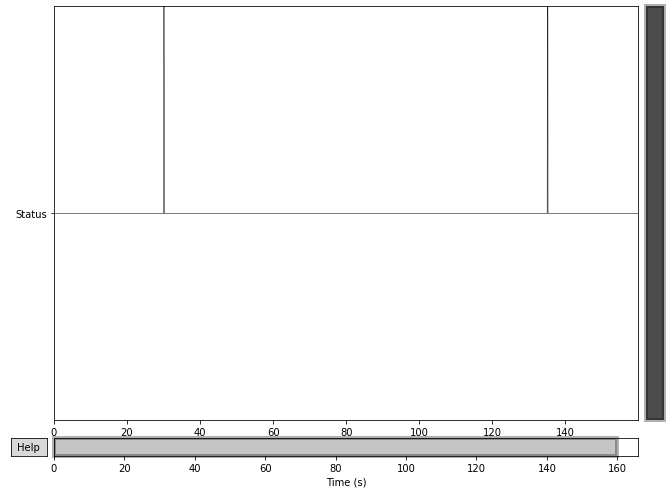

In [6]:
data_reref.copy().pick_types(eeg=False, stim=True).plot(duration=160)
plt.show()

In [7]:
events = mne.find_events(raw, stim_channel="Status")
print(events)

2 events found
Event IDs: [268]
[[ 7680     0   268]
 [34570     0   268]]


Stimuli start and stop.

In [8]:
print(data_reref)
print(data_reref.info)
print(data_reref.ch_names)

<RawEDF | Part_1_S_Trial5_emotion.bdf, 33 x 42496 (166.0 s), ~10.7 MB, data loaded>
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F3, F7, FC5, FC1, C3, T7, CP5, CP1, P3, P7, PO3, O1, ...
 chs: 32 EEG, 1 STIM
 custom_ref_applied: True
 highpass: 0.0 Hz
 lowpass: 52.0 Hz
 meas_date: 2009-07-09 17:50:54 UTC
 nchan: 33
 projs: []
 sfreq: 256.0 Hz
>
['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2', 'Status']


In [9]:
data_reref.info["sfreq"]

256.0

#### Sensor map

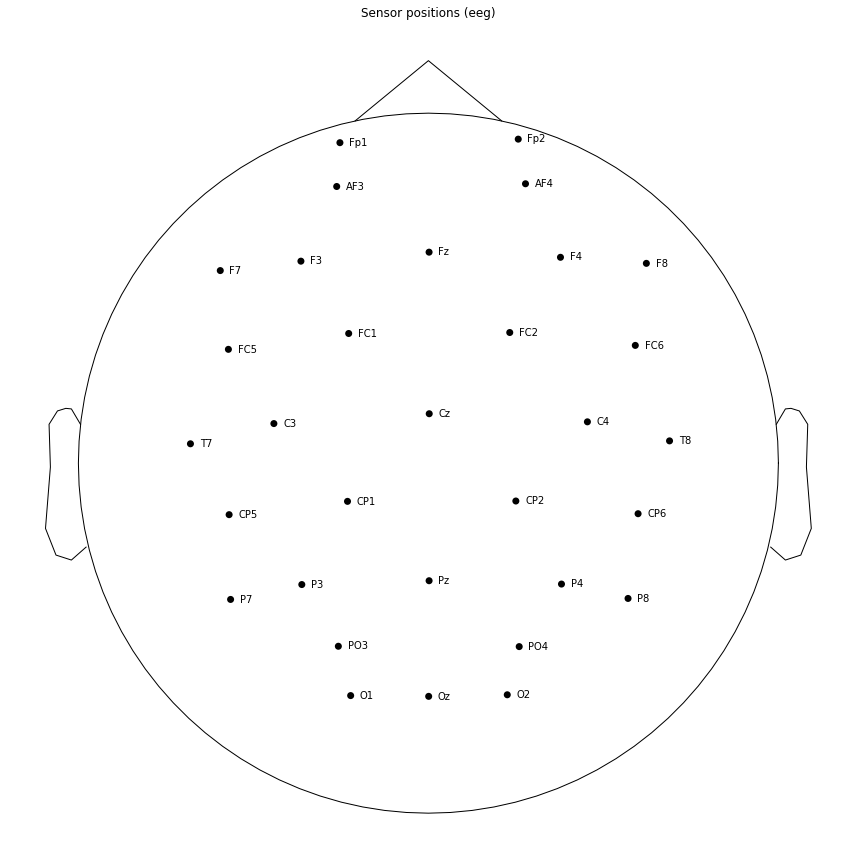

In [10]:
data_reref.set_montage('standard_1020')
data_reref.plot_sensors(show_names=True)
plt.show()

#### Filter

In [ ]:
data_reref.plot(duration=10, n_channels=32)
plt.show()

In [ ]:
data_reref.plot_psd()
plt.show()

In [ ]:
data_reref.plot_psd(fmin=45, fmax=55)
plt.show()

In [ ]:
data_filt = data_reref.copy().filter(l_freq=1, h_freq=49)

In [ ]:
data_reref.plot(duration=160, n_channels=32)
plt.show()

In [ ]:
data_filt.plot(duration=160, n_channels=32)
plt.show()

In [ ]:
data_filt.plot(duration=10, n_channels=32)
plt.show()

#### ICA

In [ ]:
ica = ICA(n_components=15, max_iter=1000, random_state=413)
ica.fit(data_filt)
ica

In [ ]:
ica.plot_sources(data_filt)
plt.show()

In [ ]:
ica.plot_components()

Project back to channels

In [ ]:
ica.exclude = [0, 1]
data_ica = data_filt.copy()
ica.apply(data_ica)

data_filt.plot(show_scrollbars=False)
data_ica.plot(show_scrollbars=False)
plt.show()

#### Cut out Stimuli presentation data

In [ ]:
# Cannot find method of conversion. Use time index / sampling frequency
event_indexes = [events[x][0] for x in range(len(events))]
sampling_freq = int(data_ica.info["sfreq"])
event_times = [int(index / sampling_freq) for index in event_indexes]

data_cropped = data_ica.copy().drop_channels(STIM_CHANNELS)
data_cropped.crop(tmin=event_times[0], tmax=event_times[1])

In [ ]:
data_cropped.plot(duration=105, n_channels=32)
plt.show()

In [ ]:
print(data_cropped.info)

## Feature Extraction

For a relatively small number of features, we let:

In [ ]:
num_freq_bands = 2
num_channels = 5
duration = int(len(data_cropped) / sampling_freq)
num_sample = int(duration / 4)

For actual model comparision, probably need multiple feature extractions with different channels and frequency bands used.

For now, stick to a set group of frequency bands and channels

In [ ]:
freq_bands = ["alpha", "beta"]
channels = ["F3", "Fz", "F4", "FC1", "FC2"]

#### Make Frequency band

In [ ]:
data_used = data_cropped.copy().pick_channels(ch_names=channels)

list_data_by_freq = []
for i in range(len(freq_bands)):
    list_data_by_freq.append(
        data_used.copy().filter(
            l_freq=FREQ_RANGES[freq_bands[i]][0], 
            h_freq=FREQ_RANGES[freq_bands[i]][1]
        )
    )

In [ ]:
print(list_data_by_freq)

In [ ]:
list_data_by_freq[0].plot(duration=105)
plt.show()

In [ ]:
list_data_by_freq[1].plot(duration=105)
plt.show()

#### Z-score data & Hilbert transform

In [ ]:
# Code from limbic-analysis-dynamics feature extraction scripts
# See https://github.com/TNEL-UCSD/limbic-analysis-dynamics/blob/master/
#     scripts/iads_gen_features.py
for data in list_data_by_freq:
    data_hilbert = data.get_data()
    # mean across time per channel
    m = np.mean(data_hilbert, axis=1)
    m = np.tile(m,(data_hilbert.shape[1],1)).T
    s = np.std(data_hilbert, axis=1, ddof=1)
    s = np.tile(s, (data_hilbert.shape[1],1)).T
    z_score = (data_hilbert - m) / s

    data.apply_function(lambda _: z_score, channel_wise=False)
    data.apply_hilbert(n_jobs=16, envelope=True)
    data.apply_function(np.square, dtype=np.float64)

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
alpha = pd.DataFrame(list_data_by_freq[0].get_data().T, columns=channels)
beta = pd.DataFrame(list_data_by_freq[1].get_data().T, columns=channels)

In [ ]:
sns.lineplot(data=alpha)

In [ ]:
sns.lineplot(data=beta)

#### Resampling & making feature array

In [ ]:
# Lose some data at the end of the recording. < 30/256 = 0.12s
num_index = len(alpha["FC1"])
idx_per_sample = int(num_index / num_sample)
sample_seps = [x * idx_per_sample for x in range(num_sample + 1)]

print("Number of samples:", num_sample)

In [ ]:
alpha_array = np.array(alpha.T)
beta_array = np.array(beta.T)

features = []
for a_ch, b_ch in zip(alpha_array, beta_array):
    channel = []
    
    for i in range(len(sample_seps) - 1):
        start = sample_seps[i]
        end = sample_seps[i+1]
        
        alpha_sample = np.mean(a_ch[start:end])
        beta_sample = np.mean(b_ch[start:end])
        
        channel.append(alpha_sample)
        channel.append(beta_sample)
        
    features.append(channel)

__!!! Note: The above code make all alpha band samples have odd index in the feature array, and even indexes for beta band.__

In [ ]:
np.shape(features)

#### Make 1D array (?)

## Extract Affect

In [ ]:
xml_path = os.path.join(dataset_path, session_path, meta_data_path)
tree = et.parse(xml_path)
root = tree.getroot()
va_results = [valence, arousal] = [int(root.attrib["feltVlnc"]), 
                                   int(root.attrib["feltArsl"])]

Following Siddarth study, classify into 4 category: "low valence low arousal", "low valence high arousal", "high valence low arousal", and "high valence high arousal".

In [ ]:
cutoff = 5
categories = {
    "lvla": 0,
    "lvha": 1,
    "hvla": 2,
    "hvha": 3
}

result = -1

if (valence <= cutoff) and (arousal <= cutoff):
    result = 0
elif (valence <= cutoff) and (arousal > cutoff):
    result = 1
elif (valence > cutoff) and (arousal <= cutoff):
    result = 2
else:
    result = 3

#### Prediction based on features

Use LDA

In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Use scikit-learn for LDA